# Predict Probabiity of Admission Using Minimal Data 

What if a hospital has only minimal data available in real-time. Is it still feasible to make predictions?

Here we report the results of using a very limited dataset.

We have taken data elements that may be found in two datasets used in management of emergency care. 

* The [Emergency Care Data Set](https://www.datadictionary.nhs.uk/data_sets/clinical_data_sets/ecds_v4/emergency_care_data_set_version_4.html) (ECDS), a standardised national data collection system used in emergency care settings in England. It captures detailed information about patient care in emergency departments, including patient demographics, arrival and departure times, clinical presentations, diagnoses and treatments, outcomes and discharge information, and referrals and follow-up care. The data ingested into ECDS comes from clinical systems used during emergency care: primarily the emergency department's Electronic Health Record (EHR) system, supplemented by the hospital's Patient Administration System (PAS), diagnostic and pathology systems, the NHS Spine for demographics, and ambulance service records when relevant. This information is collected during care, validated, formatted to ECDS standards, and submitted to NHS Digital through the Secondary Uses Service (SUS+).
* The [Operational Pressures Escalation Levels](https://www.england.nhs.uk/long-read/integrated-opel-framework-2024-to-2026/) (OPEL) Framework, a national framework used by the NHS in England to provide a consistent approach in managing daily operational challenges and system-wide escalation. It consists of four escalation levels: OPEL 1 (Green - business as usual), OPEL 2 (Amber - moderate pressure), OPEL 3 (Red - severe pressure), and OPEL 4 (Black - extreme pressure). The framework helps healthcare providers assess their operational status, coordinate responses to increasing pressures, and implement appropriate actions to maintain patient safety and care quality. Providers have to track and report certain metrics in real-time. OPEL data is not reported at patient level, but it does require preparation of metrics based on patient-level data (eg number in ED)

### Data elements found in ECDS

We have identified data elements in our own dataset that map to variables recorded in the ECDS and which have reasonable completion rates by all providers, according to data shared with us by NHS England. These are: 

| Data Element | NHS Data Dictionary Link |
|------------|-------------------|
| Activity start date and time | https://www.datadictionary.nhs.uk/data_elements/urgent_and_emergency_care_activity_start_date_and_time.html |
| Activity end date and time | https://www.datadictionary.nhs.uk/data_elements/urgent_and_emergency_care_activity_end_date_and_time.html |
| Arrival mode | https://www.datadictionary.nhs.uk/data_elements/urgent_and_emergency_care_arrival_mode__snomed_ct_.html |
| Age | https://www.datadictionary.nhs.uk/data_elements/age_at_cds_activity_date.html |
| Gender¹ | https://www.datadictionary.nhs.uk/data_elements/emergency_care_expected_date.html |
| Acuity² | https://www.datadictionary.nhs.uk/data_elements/urgent_and_emergency_care_acuity__snomed_ct_.html |
| Discharge status | https://www.datadictionary.nhs.uk/data_elements/urgent_and_emergency_care_discharge_status__snomed_ct_.html |

¹ Regarding gender, there are two fields: stated gender and phenotypic sex. Here we use the data set provided, which only includes patients with recorded categories of male or female.  
² Regarding acuity, the NHSE data dictionary links to a SNOMED-CT concept ID which has no recorded value for its member. We assume the following: 1 =  Immediate emergency care; 2 = Very urgent emergency care; ³ = Urgent emergency care, 4 = Standard emergency care, 5 = Low acuity emergency care

### Data elements found in OPEL 

OPEL requires providers to report the following parameters about their current Emergency Department (ED):  

1.	Average ambulance handover since midnight (minutes)
2.	Current 4-hour ED performance percentage (percentage)
3.	Current ED majors and resus occupancy (percentage)
4.	Current median time to treatment since midnight (minutes)
5.	Patients in ED over 12 hours (percentage)
6.	Patients in ED referred to service (percentage)

"Referred to service" in an Emergency Department context means patients who have been assessed in the ED and then referred to another medical service or specialty for further care or assessment.

We have identified data elements in our dataset that are constitutive of the reported metrics. These are:

| Data Element | Use in OPEL |
|------------|-------------------|
 Patient in Majors | Numerator of current ED majors and resus occupancy (percentage)|
| Patient in Resus | Numerator of current ED majors and resus occupancy (percentage)|
| Length of stay | Patients in ED over 12 hours (percentage)|
| Has consult request | Patients in ED referred to service (percentage)|

This notebook shows the results of modelling using only the elements covered above. 


## Would hospitals really be able to run models using these data in real-time?

The answer depends on the each provider's own data infrastruture. Such data are certainly captured in EHR, PAS or other systems, and they are sent to the SUS+ with some degree of lag. We understand from NHSE that some hospitals send updates with lags of a day or two, and/or send Type 1 acuity (the most acute) daily but not others.  

Here we take the assumption that a hospital has these data elements in electronic form, in real-time, and could hypothetically use these for predictive models.


## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from patientflow.load import set_project_root
project_root = set_project_root()

Inferred project root: /Users/zellaking/Repos/patientflow


## Load parameters and set file paths, and load data

In [4]:
import pandas as pd
from patientflow.load import load_data
from patientflow.load import set_file_paths

# set file paths
data_folder_name = 'data-public'
data_file_path = project_root / data_folder_name

data_file_path, media_file_path, model_file_path, config_path = set_file_paths(project_root, 
               data_folder_name=data_folder_name)

# load data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

# load params
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]


Configuration will be loaded from: /Users/zellaking/Repos/patientflow/config.yaml
Data files will be loaded from: /Users/zellaking/Repos/patientflow/data-public
Trained models will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public
Images will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public/media


## Train models 

In [7]:
ed_visits.columns

Index(['snapshot_date', 'prediction_time', 'visit_number', 'elapsed_los',
       'sex', 'age_group', 'arrival_method', 'current_location_type',
       'total_locations_visited', 'num_obs', 'num_obs_events', 'num_obs_types',
       'num_lab_batteries_ordered', 'has_consultation',
       'consultation_sequence', 'visited_majors', 'visited_otf',
       'visited_paeds', 'visited_rat', 'visited_resus', 'visited_sdec',
       'visited_sdec_waiting', 'visited_unknown', 'visited_utc',
       'visited_waiting', 'num_obs_blood_pressure', 'num_obs_pulse',
       'num_obs_air_or_oxygen',
       'num_obs_glasgow_coma_scale_best_motor_response',
       'num_obs_level_of_consciousness', 'num_obs_news_score_result',
       'num_obs_manchester_triage_acuity', 'num_obs_objective_pain_score',
       'num_obs_subjective_pain_score', 'num_obs_temperature',
       'num_obs_oxygen_delivery_method', 'num_obs_pupil_reaction_right',
       'num_obs_oxygen_flow_rate', 'num_obs_uclh_sskin_areas_observed',
       

In [24]:
# Reduce data to minimum
from datetime import timedelta

minimum_data_cols = ['snapshot_date', 'prediction_time', 'visit_number', 'elapsed_los', 'latest_obs_manchester_triage_acuity',
       'sex', 'age_group', 'arrival_method', 'has_consultation', 'current_location_type', 'is_admitted']

ed_visits_minimal= ed_visits[minimum_data_cols].copy()

# create majors resus column
ed_visits_minimal['is_majors_resus'] = ed_visits_minimal['current_location_type'].isin(['majors', 'resus'])

# create over 12 hours column
ed_visits_minimal.loc[:, 'over_12_hours'] = ed_visits_minimal['elapsed_los'] > timedelta(hours=12).total_seconds()

# drop other columns
ed_visits_minimal.drop(columns=['current_location_type', 'elapsed_los'], inplace=True)


In [25]:
from patientflow.prepare import create_temporal_splits

train_visits, valid_visits, test_visits = create_temporal_splits(
    ed_visits_minimal,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date",
)

Split sizes: [53801, 6519, 19494]


In [26]:
ordinal_mappings = {

    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],

    }
exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number']

In [27]:
from datetime import datetime

# Create metadata dictionary
train_dttm = datetime.now().strftime("%Y-%m-%d-%H-%M")
model_metadata = {
    "train_dttm": train_dttm,
}

# grid for hyperparameter tuning
grid = {
    'n_estimators':[30, 40, 50],
    'subsample':[0.7,0.8,0.9],
    'colsample_bytree': [0.7,0.8,0.9]
}

In [28]:
# train admissions model
from patientflow.train.emergency_demand import train_admissions_models

prediction_times = ed_visits.prediction_time.unique()

model_metadata, trained_models = train_admissions_models(
    train_visits=train_visits,
    valid_visits=valid_visits,
    test_visits=test_visits,
    grid=grid,
    exclude_from_training_data=exclude_from_training_data,
    ordinal_mappings=ordinal_mappings,
    prediction_times=prediction_times,
    model_name='admissions_minimal',
    model_metadata=model_metadata,
    visit_col='visit_number' # visit_col is needed to ensure we get only one snapshot for each visit in the training set; snapshots are randomly sampled
)


Processing: (12, 0)

Processing: (15, 30)

Processing: (6, 0)

Processing: (9, 30)

Processing: (22, 0)


In [32]:
# save models and metadata
from patientflow.train.emergency_demand import save_model, save_metadata

save_model(trained_models, "admissions_minimal", model_file_path)
save_metadata(model_metadata, model_file_path, 'model-output', 'minimal_model_metadata.json')

print(f"Models have been saved to {model_file_path}")

Models have been saved to /Users/zellaking/Repos/patientflow/trained-models/public


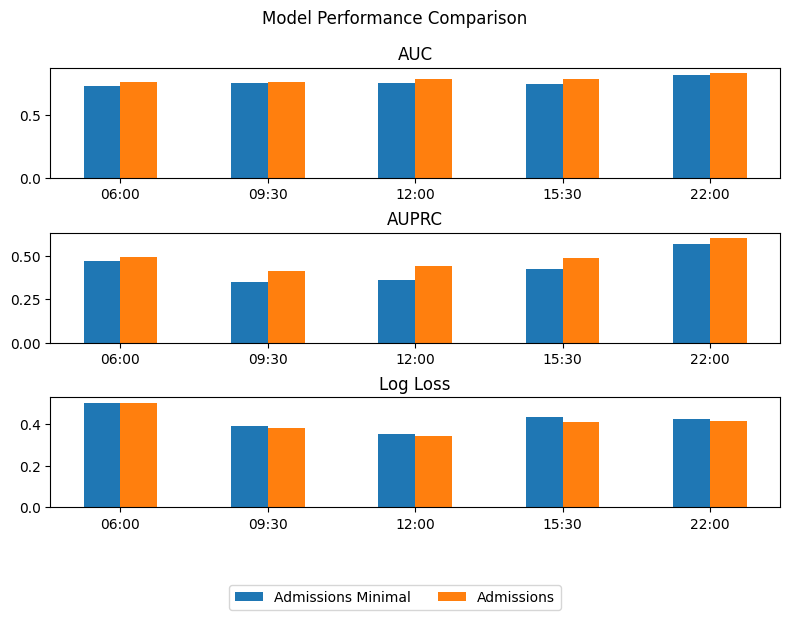

In [58]:
from patientflow.viz.model_comparison import plot_model_comparisons

prediction_times = ed_visits.prediction_time.unique()
models = {
    'admissions_minimal': 'minimal_model_metadata.json',
    'admissions': 'model_metadata.json'
}
fig = plot_model_comparisons(model_file_path, prediction_times, models)


## Feature importance plots

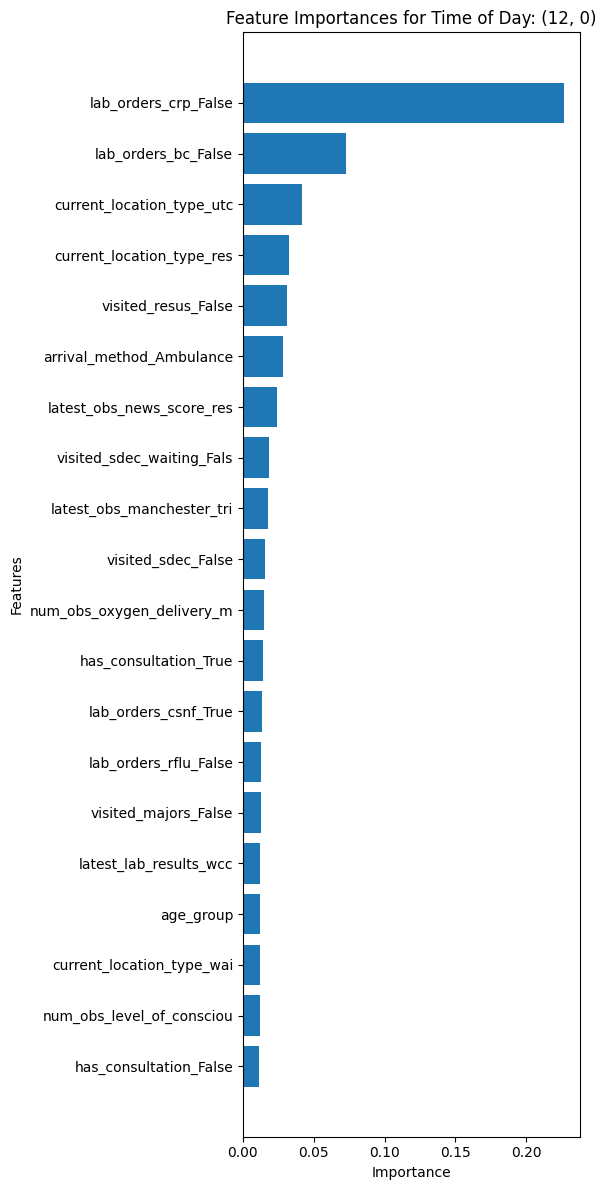

ModelLoadError: Model named ed_admission_1200_1530 not found at path: /Users/zellaking/Repos/patientflow/trained-models/public

In [57]:
from patientflow.viz.feature_plot import plot_feature_importances_individually

plot_feature_importances_individually(model_file_path=model_file_path, 
                       media_file_path=media_file_path, 
                       data_file_path = data_file_path, 
                       prediction_times = prediction_times, 
                       model_name = 'admissions')